In [1]:
# ACQUIRE
import numpy as np
import pandas as pd
import unicodedata
import re
import nltk
import json 
import warnings
warnings.filterwarnings('ignore')

# PREPARE
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import prepare
from sklearn.model_selection import train_test_split

# EXPLORE
import explore
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
from wordcloud import WordCloud

# default viz size settings
plt.rc('figure', figsize=(9, 7))
plt.rc('font', size=15)

# MODELING
from numpy.random import choice
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# EVALUATION
from sklearn.metrics import classification_report, accuracy_score

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adamgomez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Acquire

We acquire the initial dataframe of the data using the pandas `.read_json()` method. 

We read `data.json` which was acquired by running the acquire.py script using the following command in the MacOS terminal:

        python acquire.py

In [3]:
df = pd.read_json('data.json')
df

,repo,language,readme_contents
0,gocodeup/codeup-setup-script,Shell,# Codeup Setup Script\n\nSetup script for Code...
1,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w..."
2,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...
3,beetbox/beets,Python,.. image:: https://img.shields.io/pypi/v/beets...
4,scottschiller/SoundManager2,JavaScript,# SoundManager 2: JavaScript Sound for the Web...
...,...,...,...
1193,kba/awesome-ocr,None,Awesome OCR\n===========\n\n[![Awesome](https:...
1194,adamsitnik/awesome-dot-net-performance,None,# Awesome .NET Performance\nA curated list of ...
1195,jaredthecoder/awesome-vehicle-security,None,# Awesome Vehicle Security [![Awesome](https:/...
1196,rust-embedded/awesome-embedded-rust,None,# Embedded Rust\n\n[![Awesome](https://awesome...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198 entries, 0 to 1197
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1198 non-null   object
 1   language         1021 non-null   object
 2   readme_contents  1186 non-null   object
dtypes: object(3)
memory usage: 28.2+ KB


# Prepare

Utilizing the `prep_data()` function from our prepare.py file, we modify the dataframe by:

1) Cleaning the raw strings in the readme_contents column by eliminating non-alphanumeric characters  
2) Removing single character words from the raw strings  
3) Tokenizing the words using `TokTokTokenizer`  
4) Adding a `stemmed` column made from the use of `PorterStemmer()` from the `nltk` library  
5) Adding a `lemmatized` column made from the use of `WordNetLemmatizer` from the `nltk` library  
6) Removing stopwords from the lemmatized results to create the `clean` column  
- Includes the standard english stopwords and the additional words: 

            github, project, name, library, 00s, http, com, org, license, www, file, use
            
7) Adding a column `stopwords_removed` showing a count of the number of stopwords removed from lemmatized string  
8) Adding a column `doc_length` showing the total number of words in the clean strings  
9) Adding a column containing lists of the words used in each cleaned string  
10) Dropping any observations that are only instance of a language (this is necessary to stratify the dataframe when splitting later)  
11) Dropping any observations with missing data

In [5]:
df = prepare.prep_data(df, 'readme_contents')
df

,repo,language,readme_contents,stemmed,lemmatized,clean,stopwords_removed,doc_length,words
0,gocodeup/codeup-setup-script,Shell,# Codeup Setup Script\n\nSetup script for Code...,codeup setup script setup script for codeup st...,codeup setup script setup script for codeup st...,codeup setup script setup script codeup studen...,113,142,"[codeup, setup, script, setup, script, codeup,..."
1,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w...",movi applic for thi project we will be build a...,movie application for this project we will be ...,movie application building single page movie a...,386,406,"[movie, application, building, single, page, m..."
2,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...,linux kernel there are sever guid for kernel d...,linux kernel there are several guide for kerne...,linux kernel several guide kernel developer us...,45,65,"[linux, kernel, several, guide, kernel, develo..."
3,beetbox/beets,Python,.. image:: https://img.shields.io/pypi/v/beets...,imag http img shield io pypi v beet svg target...,image http img shield io pypi v beet svg targe...,image img shield io pypi v beet svg target pyp...,274,455,"[image, img, shield, io, pypi, v, beet, svg, t..."
4,scottschiller/SoundManager2,JavaScript,# SoundManager 2: JavaScript Sound for the Web...,soundmanag javascript sound for the web by wra...,soundmanager javascript sound for the web by w...,soundmanager javascript sound web wrapping ext...,339,615,"[soundmanager, javascript, sound, web, wrappin..."
...,...,...,...,...,...,...,...,...,...
990,leochuan/ViewPagerLayoutManager,Java,# ViewPager-LayoutManager [![Download](https:/...,viewpag layoutmanag download http api bintray ...,viewpager layoutmanager download http api bint...,viewpager layoutmanager download api bintray p...,74,257,"[viewpager, layoutmanager, download, api, bint..."
991,arbox/machine-learning-with-ruby,Ruby,"<img title=""Awesome Machine Learning with Ruby...",img titl awesom machin learn with rubi alt awe...,img title awesome machine learning with ruby a...,img title awesome machine learning ruby alt aw...,1068,2480,"[img, title, awesome, machine, learning, ruby,..."
992,BinaryMuse/planetary.js,JavaScript,Planetary.js\n============\n\nPlanetary.js is ...,planetari js planetari js is a javascript libr...,planetary j planetary j is a javascript librar...,planetary j planetary j javascript building aw...,107,214,"[planetary, j, planetary, j, javascript, build..."
993,xinghaochen/awesome-hand-pose-estimation,Python,# Awesome Hand Pose Estimation [![Awesome](htt...,awesom hand pose estim awesom http awesom re b...,awesome hand pose estimation awesome http awes...,awesome hand pose estimation awesome awesome b...,2194,10612,"[awesome, hand, pose, estimation, awesome, awe..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   repo               995 non-null    object
 1   language           995 non-null    object
 2   readme_contents    995 non-null    object
 3   stemmed            995 non-null    object
 4   lemmatized         995 non-null    object
 5   clean              995 non-null    object
 6   stopwords_removed  995 non-null    int64 
 7   doc_length         995 non-null    int64 
 8   words              995 non-null    object
dtypes: int64(2), object(7)
memory usage: 70.1+ KB


With the data cleaned and prepped, we can see the total number of observations available for analysis.

## Splitting the Data

In [7]:
train_validate, test = train_test_split(df, stratify = df.language, test_size = .15, random_state= 123)
train, validate = train_test_split(train_validate, stratify = train_validate.language, test_size = .20, random_state = 123)

In [8]:
train.shape, validate.shape, test.shape

((676, 9), (169, 9), (150, 9))

# Exploration

### Which languages are represented in the data?

In [9]:
train.language.value_counts()

Python              205
Java                108
C++                  68
Jupyter Notebook     56
Dart                 52
JavaScript           42
HTML                 29
Ruby                 20
Kotlin               15
C#                   12
Shell                10
Go                    9
C                     8
CSS                   6
Lua                   5
TypeScript            5
PHP                   4
Scala                 3
Objective-C           2
ActionScript          2
Rust                  2
Dockerfile            2
R                     2
Objective-C++         2
Groovy                2
Julia                 2
Swift                 2
FreeMarker            1
Name: language, dtype: int64

### What are the most common words in READMEs?

In [10]:
# Create a single massive string containing every word used in every observation
all_words = ' '.join(train.clean)

In [11]:
# Create a dataframe from this single combined string
all_words_df = pd.DataFrame(all_words.split())

In [12]:
# Identify the top ten most frequently used words
all_words_df.value_counts().head(10)

image       4025
master      3338
io          3248
data        3217
img         3013
python      2882
model       2797
learning    2732
code        2405
src         2274
dtype: int64

In [13]:
# Creating strings containing all of the words associated with several top languages
html_words = ' '.join(train[train.language=='HTML'].clean)
c_plus_plus_words = ' '.join(train[train.language=='C++'].clean)
python_words = ' '.join(train[train.language=='Python'].clean)
javascript_words = ' '.join(train[train.language=='JavaScript'].clean)
ruby_words = ' '.join(train[train.language=='Ruby'].clean)
java_words = ' '.join(train[train.language=='Java'].clean)

In [14]:
# Creating dataframes from those strings
javascript_df = pd.DataFrame(javascript_words.split())
python_df = pd.DataFrame(python_words.split())
ruby_df = pd.DataFrame(ruby_words.split())
html_df = pd.DataFrame(html_words.split())
c_plus_plus_df = pd.DataFrame(c_plus_plus_words.split())
java_df = pd.DataFrame(java_words.split())

In [15]:
# Determining word frequency for each dataframe
javascript_freq = javascript_df.value_counts()
python_freq = python_df.value_counts()
ruby_freq = ruby_df.value_counts()
html_freq = html_df.value_counts()
c_plus_plus_freq = c_plus_plus_df.value_counts()
java_freq = java_df.value_counts()
all_freq = all_words_df.value_counts()

In [16]:
word_counts = (pd.concat([all_freq, javascript_freq, python_freq, ruby_freq, html_freq, c_plus_plus_freq, java_freq], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'python', 'ruby', 'html', 'c_plus_plus', 'java'], axis=1, inplace=False) 
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
image,4025,107,1962,4,13,158,203
master,3338,132,1080,14,51,208,353
io,3248,207,1515,22,39,236,376
data,3217,294,1755,50,113,64,111
img,3013,97,1151,17,38,145,480
python,2882,35,2008,2,6,167,19
model,2797,65,1808,31,1,127,35
learning,2732,27,1708,93,6,95,28
code,2405,181,862,50,33,146,273


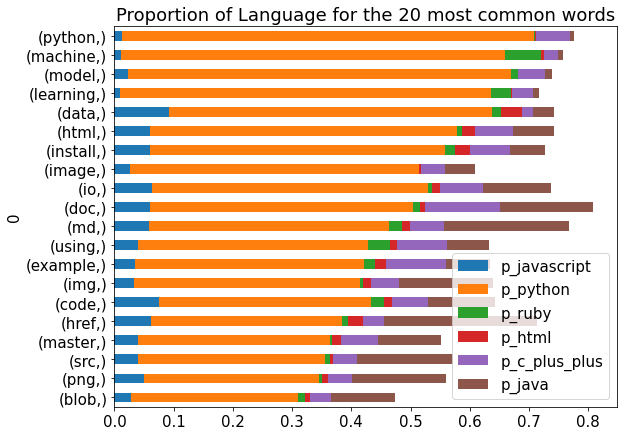

In [17]:
explore.most_common_words_props(word_counts)

### Which words show up the most in each language versus all words?

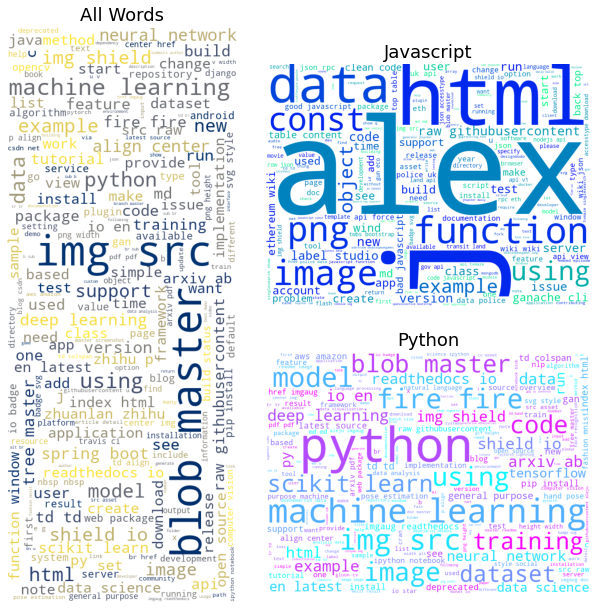

In [18]:
explore.word_cloud_1(all_words, javascript_words, python_words)

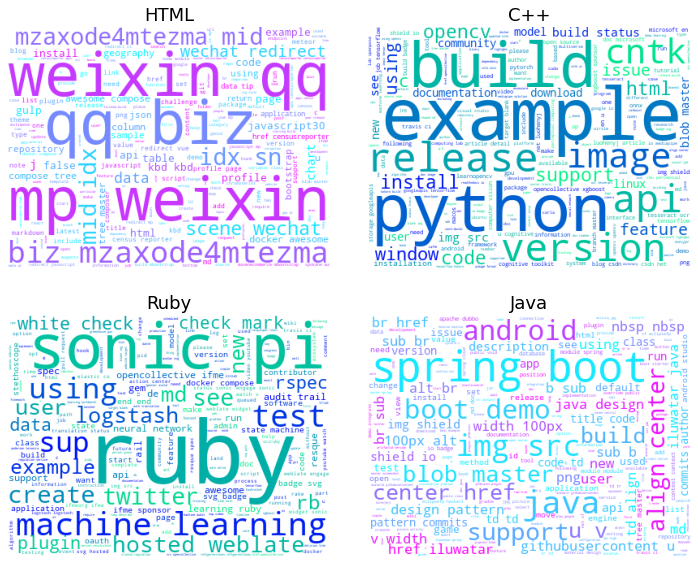

In [19]:
explore.word_cloud_2(html_words, ruby_words, c_plus_plus_words, java_words)

### What does the distribution of IDFs look like for the most common words?

In [20]:
explore.idf(all_words_df, train)

,word,total_count,num_of_documents,idf_value
0,image,4025,336,0.699082
1,master,3338,373,0.594615
2,io,3248,378,0.581299
3,data,3217,309,0.782852
4,img,3013,362,0.624549
5,python,2882,274,0.903065
6,model,2797,236,1.052361
7,learning,2732,210,1.169086
8,code,2405,408,0.504926
9,src,2274,318,0.754142


### Are there any words that uniquely identify a language of a project?

In [21]:
# Words that are uniquely attached to JavaScript readmes
word_counts[(word_counts.javascript != 0) & (word_counts.python == 0) & (word_counts.ruby == 0) & (word_counts.html == 0) & (word_counts.c_plus_plus == 0) & (word_counts.java == 0)].sort_values(by='javascript', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
ganache,96,96,0,0,0,0,0
jhipster,83,83,0,0,0,0,0
hydrogen,54,50,0,0,0,0,0
employee,53,47,0,0,0,0,0
roughviz,42,42,0,0,0,0,0
accesstype,37,37,0,0,0,0,0
designmodo,33,33,0,0,0,0,0
getstream,31,31,0,0,0,0,0
soundnode,28,28,0,0,0,0,0


In [22]:
# Words that are unique attached to Python readmes
word_counts[(word_counts.javascript == 0) & (word_counts.python != 0) & (word_counts.ruby == 0) & (word_counts.html == 0) & (word_counts.c_plus_plus == 0) & (word_counts.java == 0)].sort_values(by='python', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
imgaug,422,0,422,0,0,0,0
bert,285,0,281,0,0,0,0
catalyst,242,0,239,0,0,0,0
num,225,0,215,0,0,0,0
spacy,218,0,212,0,0,0,0
donnemartin,188,0,187,0,0,0,0
tpot,177,0,177,0,0,0,0
kaggle,231,0,176,0,0,0,0
awslabs,166,0,166,0,0,0,0


In [23]:
# Words that are unique attached to Ruby readmes
word_counts[(word_counts.javascript == 0) & (word_counts.python == 0) & (word_counts.ruby != 0) & (word_counts.html == 0) & (word_counts.c_plus_plus == 0) & (word_counts.java == 0)].sort_values(by='ruby', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
resque,57,0,0,57,0,0,0
ifme,45,0,0,45,0,0,0
resquespec,30,0,0,30,0,0,0
refugerestrooms,28,0,0,28,0,0,0
stethoscope,26,0,0,26,0,0,0
trail,24,0,0,24,0,0,0
audit,26,0,0,24,0,0,0
recalculate,23,0,0,23,0,0,0
hashrocket,17,0,0,17,0,0,0


In [24]:
# Words that are unique attached to HTML readmes
word_counts[(word_counts.javascript == 0) & (word_counts.python == 0) & (word_counts.ruby == 0) & (word_counts.html != 0) & (word_counts.c_plus_plus == 0) & (word_counts.java == 0)].sort_values(by='html', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
mzaxode4mtezma,101,0,0,0,101,0,0
kbd,152,0,0,0,86,0,0
censusreporter,55,0,0,0,55,0,0
census,63,0,0,0,50,0,0
geography,47,0,0,0,47,0,0
javascript30,44,0,0,0,44,0,0
mbootstrap,33,0,0,0,33,0,0
magento,26,0,0,0,26,0,0
reporter,21,0,0,0,21,0,0


In [25]:
# Words that are unique attached to C++ readmes
word_counts[(word_counts.javascript == 0) & (word_counts.python == 0) & (word_counts.ruby == 0) & (word_counts.html == 0) & (word_counts.c_plus_plus != 0) & (word_counts.java == 0)].sort_values(by='c_plus_plus', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
airsim,62,0,0,0,0,62,0
aseprite,58,0,0,0,0,58,0
open3d,58,0,0,0,0,58,0
carla,54,0,0,0,0,54,0
openmvg,53,0,0,0,0,53,0
luohenyj,50,0,0,0,0,50,0
qimage,45,0,0,0,0,45,0
tomahawk,43,0,0,0,0,43,0
musescore,39,0,0,0,0,39,0


In [26]:
# Words that are unique attached to java readmes
word_counts[(word_counts.javascript == 0) & (word_counts.python == 0) & (word_counts.ruby == 0) & (word_counts.html == 0) & (word_counts.c_plus_plus == 0) & (word_counts.java != 0)].sort_values(by='java', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
dubbo,169,0,0,0,0,0,169
iluwatar,143,0,0,0,0,0,143
redisson,126,0,0,0,0,0,126
mockito,105,0,0,0,0,0,105
mybatis,98,0,0,0,0,0,98
eclipsefp,85,0,0,0,0,0,85
artifactid,84,0,0,0,0,0,84
hutool,84,0,0,0,0,0,84
hikaricp,79,0,0,0,0,0,79


### Does the length of the README vary by programming language?

In [27]:
train.groupby('language').doc_length.mean().sort_values(ascending=False)

language
R                   3664.500000
Swift               1256.500000
TypeScript          1235.400000
Shell               1229.900000
Python              1100.843902
Jupyter Notebook    1016.142857
Lua                  978.200000
Go                   973.666667
CSS                  847.666667
JavaScript           813.238095
C#                   738.916667
Dart                 713.865385
Java                 595.620370
Ruby                 580.700000
PHP                  565.000000
C++                  507.220588
Groovy               467.500000
Scala                407.666667
Kotlin               406.000000
Julia                375.500000
HTML                 357.689655
Objective-C          340.500000
Objective-C++        325.000000
C                    272.125000
ActionScript         209.000000
Rust                 204.500000
FreeMarker           117.000000
Dockerfile           105.000000
Name: doc_length, dtype: float64

In [28]:
explore.t_test_loop('doc_length', train)

----------------
doc_length T-Test: R & Python
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of R and Python
H_a: There is a difference in the mean doc_length of R and Python


p-value: 0.0452884505169901
t-statistic: 1.7003751262740485
We reject the null hypothesis


The mean readme doc_length for R is larger than Python

 

----------------
doc_length T-Test: R & Jupyter Notebook
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of R and Jupyter Notebook
H_a: There is a difference in the mean doc_length of R and Jupyter Notebook


p-value: 0.008850348333377814
t-statistic: 2.4439974451227027
We reject the null hypothesis


The mean readme doc_length for R is larger than Jupyter Notebook

 

----------------
doc_length T-Test: R & Go
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of R and Go
H_a: There is a difference in the mean doc_length of R and Go


p-value: 0.044642257145470245
t-sta

----------------
doc_length T-Test: Python & HTML
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of Python and HTML
H_a: There is a difference in the mean doc_length of Python and HTML


p-value: 0.029672514197630496
t-statistic: 1.8949302687943688
We reject the null hypothesis


The mean readme doc_length for Python is larger than HTML

 

----------------
doc_length T-Test: Jupyter Notebook & Java
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of Jupyter Notebook and Java
H_a: There is a difference in the mean doc_length of Jupyter Notebook and Java


p-value: 0.005150634018454521
t-statistic: 2.595901322294214
We reject the null hypothesis


The mean readme doc_length for Jupyter Notebook is larger than Java

 

----------------
doc_length T-Test: Jupyter Notebook & C++
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of Jupyter Notebook and C++
H_a: There is a difference in the mean doc

----------------
doc_length T-Test: Groovy & Dockerfile
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of Groovy and Dockerfile
H_a: There is a difference in the mean doc_length of Groovy and Dockerfile


p-value: 0.043476587829469664
t-statistic: 3.165938864628821
We reject the null hypothesis


The mean readme doc_length for Groovy is larger than Dockerfile

 

----------------
doc_length T-Test: Scala & ActionScript
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of Scala and ActionScript
H_a: There is a difference in the mean doc_length of Scala and ActionScript


p-value: 0.047510987522127575
t-statistic: 2.4099420745715903
We reject the null hypothesis


The mean readme doc_length for Scala is larger than ActionScript

 

----------------
doc_length T-Test: Scala & Rust
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of Scala and Rust
H_a: There is a difference in the mean doc_length 

### Do different programming languages use a different number of unique words?

In [29]:
unique_word_count = {}

train_language_list = list(train.groupby('language')['doc_length'].mean().sort_values(ascending=False).index)

for language in train_language_list:
    unique_word_count[language] = len(set(' '.join(train[train.language==language].clean).split()))

In [30]:
unique_word_count = pd.DataFrame.from_dict(unique_word_count, orient='index').rename(columns={0: 'num_unique_words'})

In [31]:
unique_word_count.sort_values(by='num_unique_words', ascending=False)

,num_unique_words
Python,20345
Java,8885
Jupyter Notebook,8438
JavaScript,5933
C++,5546
Dart,5455
Shell,3222
Ruby,2936
C#,2645
HTML,2580


While this gives us a total count of the number of unique words each programming language has connected to it, this is likely to be correlated both to the total document length AND the number of observations that each language has. Languages with more observations likely have more opportunities to expand the unique word list. 

A better metric would be the average number of unique words that each language has. To do this we will need to add a column to our dataframe.

In [32]:
train['unique_word_count'] = train.words.apply(lambda x: len(set(x)))

In [33]:
train.head(1)

,repo,language,readme_contents,stemmed,lemmatized,clean,stopwords_removed,doc_length,words,unique_word_count
582,NifTK/NiftyNet,Python,# Status update - 2020-04-21\n\n⚠️ **NiftyNet ...,statu updat 2020 04 21 niftynet is not activ m...,status update 2020 04 21 niftynet is not activ...,status update 2020 04 21 niftynet actively mai...,269,690,"[status, update, 2020, 04, 21, niftynet, activ...",333


Now we can run a similar set of t-tests to compare the unique word count for each programming language

In [34]:
train.groupby('language').unique_word_count.mean().sort_values(ascending=False)

language
R                   914.500000
Shell               424.900000
TypeScript          419.000000
Lua                 392.400000
Go                  384.222222
Swift               340.000000
Jupyter Notebook    337.517857
Python              336.887805
CSS                 310.833333
C#                  303.750000
JavaScript          292.928571
PHP                 251.250000
Ruby                238.850000
Dart                229.153846
Groovy              220.500000
Java                215.898148
C++                 211.132353
Scala               189.666667
Julia               176.000000
Objective-C         171.500000
Kotlin              168.266667
C                   141.875000
ActionScript        138.500000
HTML                138.137931
Objective-C++       135.500000
Rust                106.000000
FreeMarker           58.000000
Dockerfile           55.000000
Name: unique_word_count, dtype: float64

In [35]:
explore.t_test_loop('unique_word_count', train)

----------------
unique_word_count T-Test: R & Jupyter Notebook
----------------
Hypotheses:
H_0: There is no difference in the mean unique_word_count of R and Jupyter Notebook
H_a: There is a difference in the mean unique_word_count of R and Jupyter Notebook


p-value: 0.038347618844873345
t-statistic: 1.8034672566661345
We reject the null hypothesis


The mean readme unique_word_count for R is larger than Jupyter Notebook

 

----------------
unique_word_count T-Test: R & Python
----------------
Hypotheses:
H_0: There is no difference in the mean unique_word_count of R and Python
H_a: There is a difference in the mean unique_word_count of R and Python


p-value: 0.039556466373469254
t-statistic: 1.764642960363247
We reject the null hypothesis


The mean readme unique_word_count for R is larger than Python

 

----------------
unique_word_count T-Test: R & JavaScript
----------------
Hypotheses:
H_0: There is no difference in the mean unique_word_count of R and JavaScript
H_a: There i



The mean readme unique_word_count for Lua is larger than ActionScript

 

----------------
unique_word_count T-Test: Lua & HTML
----------------
Hypotheses:
H_0: There is no difference in the mean unique_word_count of Lua and HTML
H_a: There is a difference in the mean unique_word_count of Lua and HTML


p-value: 0.0013152703896305014
t-statistic: 3.262034698300284
We reject the null hypothesis


The mean readme unique_word_count for Lua is larger than HTML

 

----------------
unique_word_count T-Test: Lua & Objective-C++
----------------
Hypotheses:
H_0: There is no difference in the mean unique_word_count of Lua and Objective-C++
H_a: There is a difference in the mean unique_word_count of Lua and Objective-C++


p-value: 0.02584191051458011
t-statistic: 2.5433302541708938
We reject the null hypothesis


The mean readme unique_word_count for Lua is larger than Objective-C++

 

----------------
unique_word_count T-Test: Lua & Rust
----------------
Hypotheses:
H_0: There is no diffe

----------------
unique_word_count T-Test: Python & Dart
----------------
Hypotheses:
H_0: There is no difference in the mean unique_word_count of Python and Dart
H_a: There is a difference in the mean unique_word_count of Python and Dart


p-value: 0.04706302570297146
t-statistic: 1.680286984593958
We reject the null hypothesis


The mean readme unique_word_count for Python is larger than Dart

 

----------------
unique_word_count T-Test: Python & Java
----------------
Hypotheses:
H_0: There is no difference in the mean unique_word_count of Python and Java
H_a: There is a difference in the mean unique_word_count of Python and Java


p-value: 0.0038532796412681946
t-statistic: 2.682120141610784
We reject the null hypothesis


The mean readme unique_word_count for Python is larger than Java

 

----------------
unique_word_count T-Test: Python & C++
----------------
Hypotheses:
H_0: There is no difference in the mean unique_word_count of Python and C++
H_a: There is a difference in the

# Model

In [36]:
tfidf = TfidfVectorizer()
tfidf

TfidfVectorizer()

In [37]:
# X_train, X_validate, X_test are transformed to sparse array representing TF-IDF values for every word

X_train = tfidf.fit_transform(train.clean)

X_validate = tfidf.transform(validate.clean)

X_test = tfidf.transform(test.clean)

In [38]:
# y_train, y_validate, y_test are simply the actual language labels

y_train = train.language
y_validate = validate.language
y_test = test.language

## Baseline

We will create two baseline models. 

The first will predict a language at random using weighted probabilities based on the distribution of the languages in the train dataset. 

The second will be based on the most common language in the train dataset.

### Baseline Mode: Weighted Random Selection

In [39]:
baseline_train_pred_random = explore.baseline_language_model(train, num_observations = train.language.shape[0])

In [40]:
train_results = pd.DataFrame(dict(actual=y_train))
train_results['base_random'] = baseline_train_pred_random
train_results

,actual,base_random
582,Python,Java
151,C++,Python
919,Java,CSS
844,Rust,Jupyter Notebook
714,Java,C++
...,...,...
608,JavaScript,Python
958,Java,Ruby
968,JavaScript,Python
961,Java,Jupyter Notebook


In [41]:
print('Baseline Model: Weighted Random Selection')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.base_random)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.base_random, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.base_random))

Baseline Model: Weighted Random Selection
Accuracy: 14.94%
---
Confusion Matrix
actual            ActionScript  C  C#  C++  CSS  Dart  Dockerfile  FreeMarker  \
base_random                                                                     
ActionScript                 0  0   0    0    0     0           0           0   
C                            0  0   0    1    0     1           0           0   
C#                           0  1   0    2    0     0           0           0   
C++                          1  3   0    7    0     7           1           0   
CSS                          0  0   0    0    0     0           0           0   
Dart                         0  0   0    7    0     5           0           0   
FreeMarker                   0  0   0    0    0     0           0           0   
Go                           0  0   1    0    1     1           0           0   
Groovy                       0  0   0    0    0     0           0           0   
HTML                         

### Baseline Model: Mode Selection

In [42]:
train_results['base_mode'] = train.language.value_counts().idxmax()
train_results

,actual,base_random,base_mode
582,Python,Java,Python
151,C++,Python,Python
919,Java,CSS,Python
844,Rust,Jupyter Notebook,Python
714,Java,C++,Python
...,...,...,...
608,JavaScript,Python,Python
958,Java,Ruby,Python
968,JavaScript,Python,Python
961,Java,Jupyter Notebook,Python


In [43]:
print('Baseline Model: Mode Selection')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.base_mode)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.base_mode, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.base_mode))

Baseline Model: Mode Selection
Accuracy: 30.33%
---
Confusion Matrix
actual     ActionScript  C  C#  C++  CSS  Dart  Dockerfile  FreeMarker  Go  \
base_mode                                                                    
Python                2  8  12   68    6    52           2           1   9   

actual     Groovy  ...  Objective-C++  PHP  Python  R  Ruby  Rust  Scala  \
base_mode          ...                                                     
Python          2  ...              2    4     205  2    20     2      3   

actual     Shell  Swift  TypeScript  
base_mode                            
Python        10      2           5  

[1 rows x 28 columns]
---
                  precision    recall  f1-score   support

    ActionScript       0.00      0.00      0.00         2
               C       0.00      0.00      0.00         8
              C#       0.00      0.00      0.00        12
             C++       0.00      0.00      0.00        68
             CSS       0.00      0.

## Logistic Regression

In [44]:
lm = LogisticRegression().fit(X_train, y_train)

In [45]:
train_results['lm_predicted'] = lm.predict(X_train)
train_results

,actual,base_random,base_mode,lm_predicted
582,Python,Java,Python,Python
151,C++,Python,Python,C++
919,Java,CSS,Python,Java
844,Rust,Jupyter Notebook,Python,Dart
714,Java,C++,Python,Java
...,...,...,...,...
608,JavaScript,Python,Python,Java
958,Java,Ruby,Python,Java
968,JavaScript,Python,Python,JavaScript
961,Java,Jupyter Notebook,Python,Java


In [46]:
print('Logistic Regression')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.lm_predicted, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.lm_predicted))

Logistic Regression
Accuracy: 68.93%
---
Confusion Matrix
actual            ActionScript  C  C#  C++  CSS  Dart  Dockerfile  FreeMarker  \
lm_predicted                                                                    
C++                          0  2   1   60    0     0           0           0   
Dart                         0  0   0    0    0    48           0           0   
HTML                         0  0   0    0    0     0           0           0   
Java                         0  2   2    1    0     0           0           1   
JavaScript                   0  0   0    0    0     0           0           0   
Jupyter Notebook             0  0   0    0    0     0           0           0   
Python                       2  4   9    7    6     4           2           0   

actual            Go  Groovy  ...  Objective-C++  PHP  Python  R  Ruby  Rust  \
lm_predicted                  ...                                              
C++                0       0  ...              2    

## Decision Tree

In [47]:
clf = DecisionTreeClassifier(max_depth = 15, random_state = 123).fit(X_train, y_train)

In [48]:
train_results['clf_predicted'] = clf.predict(X_train)
train_results

,actual,base_random,base_mode,lm_predicted,clf_predicted
582,Python,Java,Python,Python,Python
151,C++,Python,Python,C++,C++
919,Java,CSS,Python,Java,Java
844,Rust,Jupyter Notebook,Python,Dart,Rust
714,Java,C++,Python,Java,Java
...,...,...,...,...,...
608,JavaScript,Python,Python,Java,JavaScript
958,Java,Ruby,Python,Java,Java
968,JavaScript,Python,Python,JavaScript,JavaScript
961,Java,Jupyter Notebook,Python,Java,Java


In [49]:
print('Decision Tree')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.clf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.clf_predicted, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.clf_predicted))

Decision Tree
Accuracy: 89.35%
---
Confusion Matrix
actual            ActionScript  C  C#  C++  CSS  Dart  Dockerfile  FreeMarker  \
clf_predicted                                                                   
ActionScript                 1  0   0    0    0     0           0           0   
C                            0  3   0    0    0     0           0           0   
C#                           0  0   7    0    0     0           0           0   
C++                          0  5   5   68    3     1           0           0   
CSS                          0  0   0    0    3     0           0           0   
Dart                         0  0   0    0    0    51           0           0   
Dockerfile                   0  0   0    0    0     0           2           0   
FreeMarker                   0  0   0    0    0     0           0           1   
Go                           0  0   0    0    0     0           0           0   
Groovy                       0  0   0    0    0     0    

## Random Forest

In [50]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123).fit(X_train, y_train)

In [51]:
train_results['rf_predicted'] = rf.predict(X_train)
train_results

,actual,base_random,base_mode,lm_predicted,clf_predicted,rf_predicted
582,Python,Java,Python,Python,Python,Python
151,C++,Python,Python,C++,C++,Python
919,Java,CSS,Python,Java,Java,Python
844,Rust,Jupyter Notebook,Python,Dart,Rust,Python
714,Java,C++,Python,Java,Java,Python
...,...,...,...,...,...,...
608,JavaScript,Python,Python,Java,JavaScript,Python
958,Java,Ruby,Python,Java,Java,Java
968,JavaScript,Python,Python,JavaScript,JavaScript,Python
961,Java,Jupyter Notebook,Python,Java,Java,Python


In [52]:
print('Random Forest Model')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.rf_predicted, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.rf_predicted))

Random Forest Model
Accuracy: 35.36%
---
Confusion Matrix
actual        ActionScript  C  C#  C++  CSS  Dart  Dockerfile  FreeMarker  Go  \
rf_predicted                                                                    
Java                     0  0   0    0    0     0           0           0   0   
Python                   2  8  12   68    6    52           2           1   9   

actual        Groovy  ...  Objective-C++  PHP  Python  R  Ruby  Rust  Scala  \
rf_predicted          ...                                                     
Java               2  ...              0    0       0  0     0     0      0   
Python             0  ...              2    4     205  2    20     2      3   

actual        Shell  Swift  TypeScript  
rf_predicted                            
Java              0      0           0  
Python           10      2           5  

[2 rows x 28 columns]
---
                  precision    recall  f1-score   support

    ActionScript       0.00      0.00      0.00   

## K-Nearest Neighbors

In [53]:
error_rate = []
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

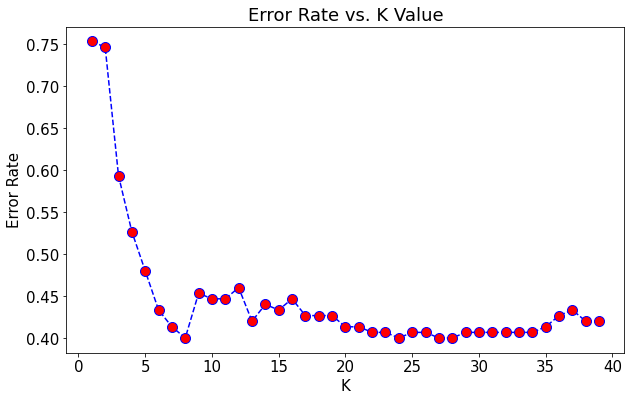

In [54]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [55]:
knn = KNeighborsClassifier(n_neighbors=13).fit(X_train, y_train)

In [56]:
train_results['knn_predicted'] = knn.predict(X_train)
train_results

,actual,base_random,base_mode,lm_predicted,clf_predicted,rf_predicted,knn_predicted
582,Python,Java,Python,Python,Python,Python,Python
151,C++,Python,Python,C++,C++,Python,Python
919,Java,CSS,Python,Java,Java,Python,Java
844,Rust,Jupyter Notebook,Python,Dart,Rust,Python,Dart
714,Java,C++,Python,Java,Java,Python,Java
...,...,...,...,...,...,...,...
608,JavaScript,Python,Python,Java,JavaScript,Python,Java
958,Java,Ruby,Python,Java,Java,Java,Java
968,JavaScript,Python,Python,JavaScript,JavaScript,Python,JavaScript
961,Java,Jupyter Notebook,Python,Java,Java,Python,Java


In [57]:
print('K-Nearest Neighbors Model')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.knn_predicted, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.knn_predicted))

K-Nearest Neighbors Model
Accuracy: 59.02%
---
Confusion Matrix
actual            ActionScript  C  C#  C++  CSS  Dart  Dockerfile  FreeMarker  \
knn_predicted                                                                   
ActionScript                 1  0   0    0    0     0           0           0   
C#                           0  0   2    0    0     0           0           0   
C++                          1  3   4   36    0     0           0           0   
CSS                          0  0   0    0    1     0           0           0   
Dart                         0  0   1    3    0    50           0           0   
Go                           0  0   0    0    0     0           0           0   
HTML                         0  0   0    0    2     0           0           0   
Java                         0  3   3    9    0     2           0           1   
JavaScript                   0  0   0    0    0     0           0           0   
Jupyter Notebook             0  0   0    4   

## Validation - Checking for Overfitting

We will check the following models for overfitting:
1) Baseline Random Weighted Choice  
2) Baseline Mode  
3) Logistic Regression  
4) Decision Tree  
5) Random Forest  

### Baseline Model: Weighted Random Selection -  Performance on Validate Set

In [58]:
validate_results = pd.DataFrame(dict(actual=y_validate))

In [59]:
baseline_validate_pred_random = explore.baseline_language_model(train, num_observations = validate.language.shape[0])

In [60]:
validate_results['base_random'] = baseline_validate_pred_random
validate_results.head()

,actual,base_random
858,Dart,HTML
163,C++,Jupyter Notebook
760,Java,Python
902,Java,Python
756,Kotlin,Jupyter Notebook


In [61]:
print('Baseline Model: Weighted Random Selection - VALIDATE SET PERFORMANCE')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.base_random)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.base_random, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.base_random))

Baseline Model: Weighted Random Selection - VALIDATE SET PERFORMANCE
Accuracy: 14.20%
---
Confusion Matrix
actual            C  C#  C++  CSS  Dart  FreeMarker  Go  HTML  Java  \
base_random                                                           
ActionScript      0   0    0    0     1           0   0     0     0   
C                 0   1    0    0     0           0   0     0     0   
C#                0   0    0    0     0           0   0     0     0   
C++               0   0    1    1     2           0   0     1     3   
CSS               0   0    0    0     0           0   0     1     0   
Dart              0   0    2    0     0           0   0     0     3   
Go                0   0    0    0     0           0   0     0     1   
HTML              0   0    1    0     2           0   0     1     1   
Java              0   0    2    0     2           0   0     2     2   
JavaScript        0   0    0    1     0           1   1     1     3   
Julia             0   0    0    0     0  

### Baseline Model: Mode Selection - Performance on Validate Set

In [62]:
validate_results['base_mode'] = train.language.value_counts().idxmax()
validate_results.head()

,actual,base_random,base_mode
858,Dart,HTML,Python
163,C++,Jupyter Notebook,Python
760,Java,Python,Python
902,Java,Python,Python
756,Kotlin,Jupyter Notebook,Python


In [63]:
print('Baseline Model: Mode Selection - VALIDATE SET PERFORMANCE')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.base_mode)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.base_mode, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.base_mode))

Baseline Model: Mode Selection - VALIDATE SET PERFORMANCE
Accuracy: 30.18%
---
Confusion Matrix
actual     C  C#  C++  CSS  Dart  FreeMarker  Go  HTML  Java  JavaScript  \
base_mode                                                                  
Python     2   3   17    2    13           1   2     7    27          11   

actual     Jupyter Notebook  Kotlin  Lua  Objective-C  PHP  Python  Ruby  \
base_mode                                                                  
Python                   14       4    2            1    1      51     5   

actual     Scala  Shell  TypeScript  
base_mode                            
Python         1      3           2  
---
                  precision    recall  f1-score   support

               C       0.00      0.00      0.00         2
              C#       0.00      0.00      0.00         3
             C++       0.00      0.00      0.00        17
             CSS       0.00      0.00      0.00         2
            Dart       0.00      0.00

### Logistic Regression - Performance on Validate Set

In [64]:
validate_results['lm_predicted'] = lm.predict(X_validate)
validate_results.head()

,actual,base_random,base_mode,lm_predicted
858,Dart,HTML,Python,Dart
163,C++,Jupyter Notebook,Python,Python
760,Java,Python,Python,Java
902,Java,Python,Python,Java
756,Kotlin,Jupyter Notebook,Python,Java


In [65]:
print('Logistic Regression - VALIDATE SET PERFORMANCE')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.lm_predicted, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.lm_predicted))

Logistic Regression - VALIDATE SET PERFORMANCE
Accuracy: 56.21%
---
Confusion Matrix
actual            C  C#  C++  CSS  Dart  FreeMarker  Go  HTML  Java  \
lm_predicted                                                          
C++               0   0    8    0     0           0   0     0     1   
Dart              0   0    0    0    11           0   0     0     0   
Java              0   2    2    2     1           1   0     0    23   
JavaScript        0   0    0    0     0           0   0     0     0   
Jupyter Notebook  0   0    0    0     0           0   1     0     0   
Python            2   1    7    0     1           0   1     7     3   

actual            JavaScript  Jupyter Notebook  Kotlin  Lua  Objective-C  PHP  \
lm_predicted                                                                    
C++                        0                 0       0    0            0    0   
Dart                       1                 0       0    0            1    0   
Java                  

### Decision Tree - Performance on Validate Set

In [66]:
validate_results['clf_predicted'] = clf.predict(X_validate)
validate_results.head()

,actual,base_random,base_mode,lm_predicted,clf_predicted
858,Dart,HTML,Python,Dart,Dart
163,C++,Jupyter Notebook,Python,Python,C++
760,Java,Python,Python,Java,Java
902,Java,Python,Python,Java,Java
756,Kotlin,Jupyter Notebook,Python,Java,Dart


In [67]:
print('Decision Tree Model - VALIDATE SET')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.clf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.clf_predicted, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.clf_predicted))

Decision Tree Model - VALIDATE SET
Accuracy: 57.40%
---
Confusion Matrix
actual            C  C#  C++  CSS  Dart  FreeMarker  Go  HTML  Java  \
clf_predicted                                                         
C#                0   1    0    0     0           0   0     0     0   
C++               2   2   13    1     0           0   0     3     4   
Dart              0   0    0    0    12           0   0     0     0   
Go                0   0    0    0     0           0   1     0     0   
HTML              0   0    0    0     1           0   0     1     0   
Java              0   0    2    1     0           1   0     0    16   
JavaScript        0   0    0    0     0           0   0     2     0   
Jupyter Notebook  0   0    0    0     0           0   0     0     0   
Kotlin            0   0    0    0     0           0   0     0     4   
Lua               0   0    0    0     0           0   0     0     0   
Objective-C       0   0    1    0     0           0   0     0     1   
Pyth

### Random Forest - Performance on Validate Set

In [68]:
validate_results['rf_predicted'] = rf.predict(X_validate)
validate_results.head()

,actual,base_random,base_mode,lm_predicted,clf_predicted,rf_predicted
858,Dart,HTML,Python,Dart,Dart,Python
163,C++,Jupyter Notebook,Python,Python,C++,Python
760,Java,Python,Python,Java,Java,Python
902,Java,Python,Python,Java,Java,Python
756,Kotlin,Jupyter Notebook,Python,Java,Dart,Java


In [69]:
print('Random Forest - VALIDATE SET PERFORMANCE')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.rf_predicted, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.rf_predicted))

Random Forest - VALIDATE SET PERFORMANCE
Accuracy: 33.73%
---
Confusion Matrix
actual        C  C#  C++  CSS  Dart  FreeMarker  Go  HTML  Java  JavaScript  \
rf_predicted                                                                  
Java          0   0    0    0     0           0   0     0     6           0   
Python        2   3   17    2    13           1   2     7    21          11   

actual        Jupyter Notebook  Kotlin  Lua  Objective-C  PHP  Python  Ruby  \
rf_predicted                                                                  
Java                         0       2    0            0    0       0     0   
Python                      14       2    2            1    1      51     5   

actual        Scala  Shell  TypeScript  
rf_predicted                            
Java              0      0           0  
Python            1      3           2  
---
                  precision    recall  f1-score   support

               C       0.00      0.00      0.00         2
  

## Testing top Performing Model
1) Baseline Model: Weighted Random Selection  
2) Baseline Model: Mode Selection    
3) Logistic Regression

### Baseline Model: Weighted Random Selection - Performance on Test Set

In [70]:
test_results = pd.DataFrame(dict(actual=y_test))

In [71]:
baseline_test_pred_random = explore.baseline_language_model(train, num_observations = test.language.shape[0])

In [72]:
test_results['base_random'] = baseline_test_pred_random
test_results.head()

,actual,base_random
247,Jupyter Notebook,HTML
782,C#,Java
868,C,Kotlin
861,Dart,Python
296,Jupyter Notebook,C++


In [73]:
print('Baseline Model: Weighted Random Selection - TEST SET PERFORMANCE')
print('Accuracy: {:.2%}'.format(accuracy_score(test_results.actual, test_results.base_random)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test_results.base_random, test_results.actual))
print('---')
print(classification_report(test_results.actual, test_results.base_random))

Baseline Model: Weighted Random Selection - TEST SET PERFORMANCE
Accuracy: 13.33%
---
Confusion Matrix
actual            C  C#  C++  CSS  Dart  FreeMarker  Go  HTML  Java  \
base_random                                                           
C                 0   0    0    0     0           0   0     0     0   
C#                0   0    1    0     1           0   0     0     0   
C++               0   0    1    0     2           0   0     2     2   
CSS               0   0    0    0     0           0   0     0     0   
Dart              0   0    1    0     0           0   0     0     1   
Dockerfile        0   0    0    0     0           1   0     0     0   
HTML              1   1    0    0     2           0   0     1     1   
Java              0   1    2    1     1           0   1     0     4   
JavaScript        0   0    3    0     0           0   0     0     2   
Jupyter Notebook  0   0    0    0     0           0   0     1     1   
Kotlin            1   0    0    0     0      

### Baseline Model: Mode Selection - Performance on Test Set

In [74]:
test_results['base_mode'] = train.language.value_counts().idxmax()
test_results.head()

,actual,base_random,base_mode
247,Jupyter Notebook,HTML,Python
782,C#,Java,Python
868,C,Kotlin,Python
861,Dart,Python,Python
296,Jupyter Notebook,C++,Python


In [75]:
print('Baseline Model: Mode Selection - TEST SET PERFORMANCE')
print('Accuracy: {:.2%}'.format(accuracy_score(test_results.actual, test_results.base_mode)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test_results.base_mode, test_results.actual))
print('---')
print(classification_report(test_results.actual, test_results.base_mode))

Baseline Model: Mode Selection - TEST SET PERFORMANCE
Accuracy: 30.00%
---
Confusion Matrix
actual     C  C#  C++  CSS  Dart  FreeMarker  Go  HTML  Java  JavaScript  ...  \
base_mode                                                                 ...   
Python     2   3   15    1    12           1   2     7    24           9  ...   

actual     Jupyter Notebook  Kotlin  Lua  Objective-C  PHP  Python  Ruby  \
base_mode                                                                  
Python                   13       3    1            1    1      45     5   

actual     Scala  Shell  TypeScript  
base_mode                            
Python         1      2           1  

[1 rows x 21 columns]
---
                  precision    recall  f1-score   support

               C       0.00      0.00      0.00         2
              C#       0.00      0.00      0.00         3
             C++       0.00      0.00      0.00        15
             CSS       0.00      0.00      0.00         1
   

### Logistic Regression - Performance on Test Set

In [76]:
test_results['lm_predicted'] = lm.predict(X_test)
test_results.head()

,actual,base_random,base_mode,lm_predicted
247,Jupyter Notebook,HTML,Python,Jupyter Notebook
782,C#,Java,Python,Java
868,C,Kotlin,Python,Java
861,Dart,Python,Python,Dart
296,Jupyter Notebook,C++,Python,Python


In [77]:
print('Logistic Regression Model - TEST SET')
print('Accuracy: {:.2%}'.format(accuracy_score(test_results.actual, test_results.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test_results.lm_predicted, test_results.actual))
print('---')
print(classification_report(test_results.actual, test_results.lm_predicted))

Logistic Regression Model - TEST SET
Accuracy: 56.00%
---
Confusion Matrix
actual            C  C#  C++  CSS  Dart  FreeMarker  Go  HTML  Java  \
lm_predicted                                                          
C++               0   0    4    0     0           0   0     0     0   
Dart              0   0    1    0    11           0   0     0     2   
Java              2   2    2    0     0           1   0     2    20   
Jupyter Notebook  0   0    0    0     0           0   0     0     0   
Python            0   1    8    1     1           0   2     5     2   

actual            JavaScript  ...  Jupyter Notebook  Kotlin  Lua  Objective-C  \
lm_predicted                  ...                                               
C++                        0  ...                 0       0    0            0   
Dart                       0  ...                 0       0    0            0   
Java                       2  ...                 0       3    0            0   
Jupyter Notebook      

# Conclusion